## Running some CLI commands to download dataset from Kaggle

In [1]:
# make a kaggle root directory if it doesn't exist - normally the directory 
# is automatically created when you pip install kaggle

!mkdir ~/.kaggle

mkdir: /Users/peterchettiar/.kaggle: File exists


In [2]:
# now to copy the kaggle json file (containing the api key) to the kaggle folder

!cp /Users/peterchettiar/Downloads/kaggle.json /Users/peterchettiar/.kaggle/kaggle.json

In [3]:
# changing the permissions of the file

!chmod 600 /Users/peterchettiar/.kaggle/kaggle.json

In [4]:
# downloading the dataset

!kaggle datasets download -d ranadeep/credit-risk-dataset

 97%|█████████████████████████████████████▊ | 98.0M/101M [00:06<00:00, 20.6MB/s]
100%|████████████████████████████████████████| 101M/101M [00:06<00:00, 16.9MB/s]


In [5]:
# let's create a directory

!mkdir credit-risk-dataset

In [6]:
# now to unzip the contents of the downloaded folder

!unzip credit-risk-dataset.zip -d credit-risk-dataset

Archive:  credit-risk-dataset.zip
  inflating: credit-risk-dataset/LCDataDictionary.xlsx  
  inflating: credit-risk-dataset/loan/loan.csv  


## 1. Importing the necessary libraries

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
pd.set_option('display.max_columns', 200)

In [8]:
# Loading dataset

loan_df = pd.read_csv('credit-risk-dataset/loan/loan.csv')

loan_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# lets make a copy of the raw dataset for analytics and preprocessing purposes

df = loan_df.copy()

## 2. Train-Test Split

In [10]:
train_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     random_state=42)

In [11]:
# sorting the columns in the dataframe alphabetically - easier to read the description of the column in data dictionary

train_df = train_df.sort_index(axis=1).reset_index(drop=True)

## 3. Exploratory Data Analysis (EDA) - Training Set

Before proceeding with cleaning of the dataset, we need to try and reduce the number of of features that we have. There are 74 columns in the raw dataset, it would be prudent to take the following steps to extract the features we need:

1. Dropping columns with a lot of missing values
2. Feature selection - high correlation, low variance, feature importance using random forest
3. We can now visualise our features by plotting their distribution to better understand them


### 3.1 Dropping columns
Given there are 74 columns in the raw dataset, there is no point in proceeding without dropping columns with over 97% missing values first.

In [12]:
# we would also be dropping columns that have more than a 100,000 missing values - this is not a standard practice and one
# that was taken on a adhoc discretion basis

train_df.drop(columns=[col for col in train_df.columns.to_list() if train_df[col].isnull().sum() > 100000 or \
 (train_df[col].isnull().sum() / len(train_df)) >= 0.97], inplace=True)

In [13]:
# lets now just drop the rows that has NaN values - its > 100,000 but its ok considering our large training set

train_df.dropna(inplace=True)

In [14]:
# now that's out of the way, we can do some basic cleaning of the training dataset

def convert_to_date(df:pd.DataFrame(), keywords:[]) -> pd.DataFrame():

    tmp = df.copy()

    for col in tmp.columns:
        for keyword in keywords:
            if keyword in col:
                tmp[col] = pd.to_datetime(tmp[col],errors='coerce', format= "%b-%Y")

    return tmp

In [15]:
train_df = convert_to_date(train_df, ['issue_d','last_credit_pull_d','last_pymnt_d','_cr_line'])
train_df.drop(columns='url', inplace=True)  # url is not useful

### 3.2.1 Feature Selection - Removing Correlated Variables



In [16]:
def high_correlated_cols(dataframe, corr_th=0.70):
    # Select only the numeric columns from the DataFrame
    numeric_dataframe = dataframe.select_dtypes(include='number')
    col_corr = set()  # set of all the names of correlated columns
    
    cor_matrix = numeric_dataframe.corr() 
    for i in range(len(cor_matrix.columns)): 
        for j in range(i):
            if abs(cor_matrix.iloc[i,j]) > corr_th:  # we are interested in absolute coeff value
                colname = cor_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    
    return col_corr

In [17]:
numeric_col_drop = list(high_correlated_cols(train_df))
numeric_col_drop.remove('loan_amnt')  # loan_amnt is target variable

train_df.drop(columns=numeric_col_drop, inplace=True)
train_df.head()

,acc_now_delinq,addr_state,annual_inc,application_type,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,emp_title,funded_amnt,grade,home_ownership,id,initial_list_status,inq_last_6mths,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,open_acc,out_prncp,policy_code,pub_rec,purpose,pymnt_plan,revol_bal,revol_util,sub_grade,term,title,tot_coll_amt,tot_cur_bal,total_acc,total_pymnt,total_rec_int,total_rec_late_fee,verification_status,zip_code
0,0.0,CT,47000.0,INDIVIDUAL,0.0,0.0,1.0,36.21,2004-07-01,5 years,Early Childhood Clinician,16000.0,D,OWN,24043908,w,1.0,16.29,2014-08-01,2016-01-01,391.56,2016-01-01,16000.0,Current,20.0,12691.06,1.0,0.0,debt_consolidation,n,3463.0,24.4,D2,60 months,Debt consolidation,0.0,145956.0,44.0,6698.74,3389.80,0.0,Not Verified,063xx
1,0.0,MA,90000.0,INDIVIDUAL,0.0,0.0,4.0,17.83,1999-02-01,7 years,Regional Director,6350.0,C,MORTGAGE,65677198,f,1.0,12.59,2015-11-01,2016-01-01,212.71,2016-01-01,6350.0,Current,16.0,6203.91,1.0,0.0,debt_consolidation,n,4007.0,17.6,C2,36 months,Debt consolidation,0.0,163186.0,47.0,208.27,62.18,0.0,Source Verified,011xx
3,0.0,WA,55000.0,INDIVIDUAL,0.0,0.0,1.0,8.16,1992-10-01,8 years,customer service,4800.0,B,MORTGAGE,23133441,w,0.0,11.67,2014-07-01,2016-01-01,158.68,2016-01-01,4800.0,Current,11.0,2740.41,1.0,0.0,debt_consolidation,n,1543.0,10.0,B4,36 months,Debt consolidation,0.0,174829.0,17.0,2697.56,637.97,0.0,Not Verified,984xx
4,0.0,NY,34000.0,INDIVIDUAL,0.0,0.0,1.0,28.24,2000-05-01,< 1 year,Insurance Agent,4500.0,C,RENT,28693850,w,1.0,12.99,2014-10-01,2016-01-01,151.61,2015-10-01,4500.0,Late (31-120 days),17.0,3189.00,1.0,1.0,debt_consolidation,n,6657.0,58.9,C1,36 months,Debt consolidation,0.0,19204.0,49.0,1819.32,508.32,0.0,Not Verified,140xx
5,0.0,TX,63000.0,INDIVIDUAL,0.0,0.0,0.0,39.91,1981-09-01,10+ years,Teacher,9000.0,C,OWN,31637327,f,0.0,13.35,2014-10-01,2016-01-01,304.77,2016-01-01,9000.0,Current,8.0,5918.28,1.0,0.0,debt_consolidation,n,31807.0,74.5,C2,36 months,Debt consolidation,0.0,100924.0,25.0,4260.10,1178.38,0.0,Not Verified,785xx


### 3.2.2 Feature Selection - Applying a Low Variance Filter

In [18]:
# so now we want to apply a low variance filter on the numeric columns of our train dataset

def low_variance_filter(df:pd.DataFrame(), var_threshold=10):
    numeric_df = df.select_dtypes(include='number')
    numeric_cols = numeric_df.columns
    low_var_list = []

    variance = numeric_df.var()
    for i in range(len(variance)):
        if variance[i] < var_threshold:
            low_var_list.append(numeric_cols[i])

    return low_var_list

In [19]:
train_df.drop(columns=low_variance_filter(train_df), inplace=True)
train_df.head()

,addr_state,annual_inc,application_type,collection_recovery_fee,dti,earliest_cr_line,emp_length,emp_title,funded_amnt,grade,home_ownership,id,initial_list_status,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,open_acc,out_prncp,purpose,pymnt_plan,revol_bal,revol_util,sub_grade,term,title,tot_coll_amt,tot_cur_bal,total_acc,total_pymnt,total_rec_int,total_rec_late_fee,verification_status,zip_code
0,CT,47000.0,INDIVIDUAL,0.0,36.21,2004-07-01,5 years,Early Childhood Clinician,16000.0,D,OWN,24043908,w,16.29,2014-08-01,2016-01-01,391.56,2016-01-01,16000.0,Current,20.0,12691.06,debt_consolidation,n,3463.0,24.4,D2,60 months,Debt consolidation,0.0,145956.0,44.0,6698.74,3389.80,0.0,Not Verified,063xx
1,MA,90000.0,INDIVIDUAL,0.0,17.83,1999-02-01,7 years,Regional Director,6350.0,C,MORTGAGE,65677198,f,12.59,2015-11-01,2016-01-01,212.71,2016-01-01,6350.0,Current,16.0,6203.91,debt_consolidation,n,4007.0,17.6,C2,36 months,Debt consolidation,0.0,163186.0,47.0,208.27,62.18,0.0,Source Verified,011xx
3,WA,55000.0,INDIVIDUAL,0.0,8.16,1992-10-01,8 years,customer service,4800.0,B,MORTGAGE,23133441,w,11.67,2014-07-01,2016-01-01,158.68,2016-01-01,4800.0,Current,11.0,2740.41,debt_consolidation,n,1543.0,10.0,B4,36 months,Debt consolidation,0.0,174829.0,17.0,2697.56,637.97,0.0,Not Verified,984xx
4,NY,34000.0,INDIVIDUAL,0.0,28.24,2000-05-01,< 1 year,Insurance Agent,4500.0,C,RENT,28693850,w,12.99,2014-10-01,2016-01-01,151.61,2015-10-01,4500.0,Late (31-120 days),17.0,3189.00,debt_consolidation,n,6657.0,58.9,C1,36 months,Debt consolidation,0.0,19204.0,49.0,1819.32,508.32,0.0,Not Verified,140xx
5,TX,63000.0,INDIVIDUAL,0.0,39.91,1981-09-01,10+ years,Teacher,9000.0,C,OWN,31637327,f,13.35,2014-10-01,2016-01-01,304.77,2016-01-01,9000.0,Current,8.0,5918.28,debt_consolidation,n,31807.0,74.5,C2,36 months,Debt consolidation,0.0,100924.0,25.0,4260.10,1178.38,0.0,Not Verified,785xx


### 3.2.3 Feature Selection - Feature importance using RF

In [20]:
# let's drop ID variables as these are just unique numbers
drop_identifiers_list = [col for col in train_df.columns.tolist() if 'id' not in col]

train_df = train_df[drop_identifiers_list]

In [21]:
def encode_categories(df:pd.DataFrame()) -> pd.DataFrame():
    tmp = df.copy()

    # first thing we need to do is to identfy categorical variables in the dataframe
    category_col = [col for col in tmp.columns if tmp[col].dtype == 'object' and tmp[col].nunique() < 100]
    display(category_col)

    # lets proceed with encoding the categories using LabelEncoder()
    for col in category_col:
        le = LabelEncoder()
        tmp[col] = le.fit_transform(tmp[col])

    return tmp

train_df = encode_categories(train_df)
train_df.head()

['addr_state',
 'application_type',
 'emp_length',
 'grade',
 'home_ownership',
 'initial_list_status',
 'loan_status',
 'purpose',
 'pymnt_plan',
 'sub_grade',
 'term',
 'verification_status']

,addr_state,annual_inc,application_type,collection_recovery_fee,dti,earliest_cr_line,emp_length,emp_title,funded_amnt,grade,home_ownership,initial_list_status,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,open_acc,out_prncp,purpose,pymnt_plan,revol_bal,revol_util,sub_grade,term,title,tot_coll_amt,tot_cur_bal,total_acc,total_pymnt,total_rec_int,total_rec_late_fee,verification_status,zip_code
0,6,47000.0,0,0.0,36.21,2004-07-01,5,Early Childhood Clinician,16000.0,3,4,1,16.29,2014-08-01,2016-01-01,391.56,2016-01-01,16000.0,1,20.0,12691.06,2,0,3463.0,24.4,16,1,Debt consolidation,0.0,145956.0,44.0,6698.74,3389.80,0.0,0,063xx
1,19,90000.0,0,0.0,17.83,1999-02-01,7,Regional Director,6350.0,2,1,0,12.59,2015-11-01,2016-01-01,212.71,2016-01-01,6350.0,1,16.0,6203.91,2,0,4007.0,17.6,11,0,Debt consolidation,0.0,163186.0,47.0,208.27,62.18,0.0,1,011xx
3,47,55000.0,0,0.0,8.16,1992-10-01,8,customer service,4800.0,1,1,1,11.67,2014-07-01,2016-01-01,158.68,2016-01-01,4800.0,1,11.0,2740.41,2,0,1543.0,10.0,8,0,Debt consolidation,0.0,174829.0,17.0,2697.56,637.97,0.0,0,984xx
4,34,34000.0,0,0.0,28.24,2000-05-01,10,Insurance Agent,4500.0,2,5,1,12.99,2014-10-01,2016-01-01,151.61,2015-10-01,4500.0,7,17.0,3189.00,2,0,6657.0,58.9,10,0,Debt consolidation,0.0,19204.0,49.0,1819.32,508.32,0.0,0,140xx
5,43,63000.0,0,0.0,39.91,1981-09-01,1,Teacher,9000.0,2,4,0,13.35,2014-10-01,2016-01-01,304.77,2016-01-01,9000.0,1,8.0,5918.28,2,0,31807.0,74.5,11,0,Debt consolidation,0.0,100924.0,25.0,4260.10,1178.38,0.0,0,785xx


In [22]:
# moving forward to the random forest feature selection - since RF only takes in numeric values, we need to drop 
# the 'object' dtype

train_df = train_df.select_dtypes(include='number')

# we also have to split train df
train_X, train_y = train_df.drop(columns='loan_status').reset_index(drop=True), train_df.loan_status.reset_index(drop=True)

# intialising the model, then fit
model = RandomForestRegressor(max_depth=10, random_state=42)
model.fit(train_X,train_y)

RandomForestRegressor(max_depth=10, random_state=42)

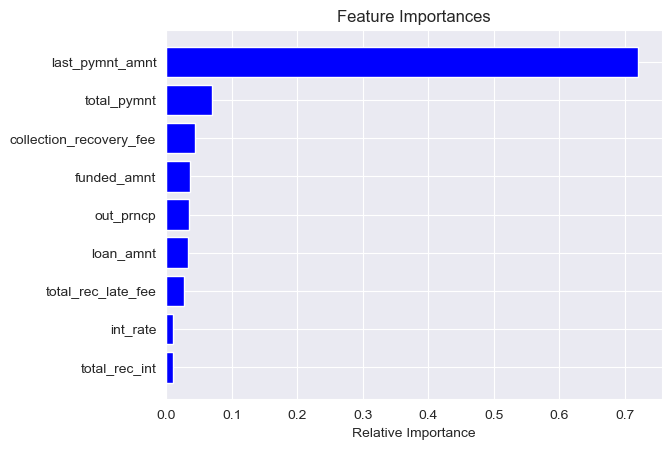

In [23]:
# lets now plot the feature importance
features = train_X.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [24]:
feature_selection = [features[i] for i in indices]

train_X = train_X[feature_selection]

train_X.head()

,total_rec_int,int_rate,total_rec_late_fee,loan_amnt,out_prncp,funded_amnt,collection_recovery_fee,total_pymnt,last_pymnt_amnt
0,3389.80,16.29,0.0,16000.0,12691.06,16000.0,0.0,6698.74,391.56
1,62.18,12.59,0.0,6350.0,6203.91,6350.0,0.0,208.27,212.71
2,637.97,11.67,0.0,4800.0,2740.41,4800.0,0.0,2697.56,158.68
3,508.32,12.99,0.0,4500.0,3189.00,4500.0,0.0,1819.32,151.61
4,1178.38,13.35,0.0,9000.0,5918.28,9000.0,0.0,4260.10,304.77


### 3.4 Distribution Plots

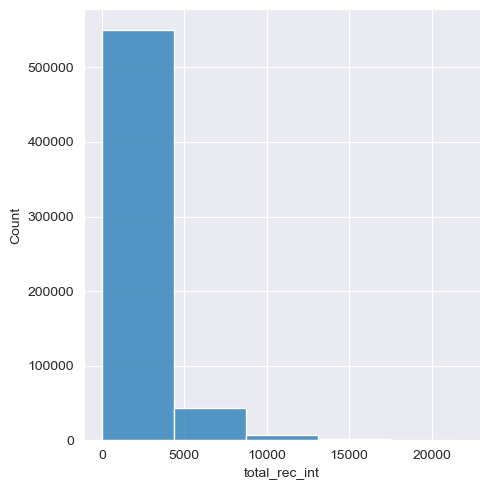

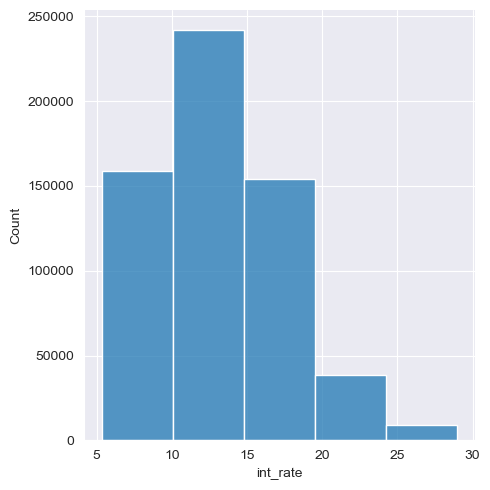

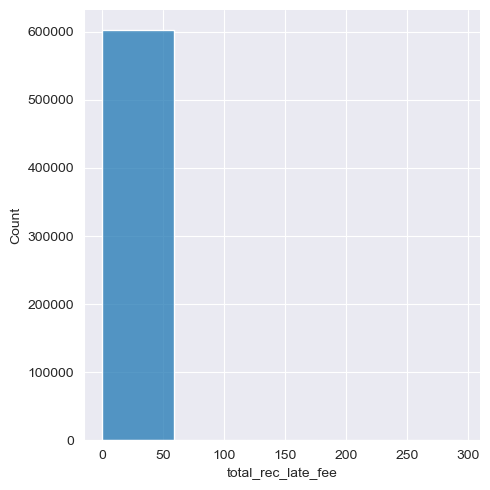

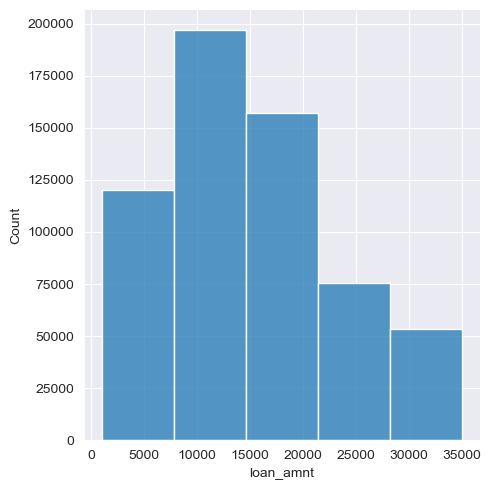

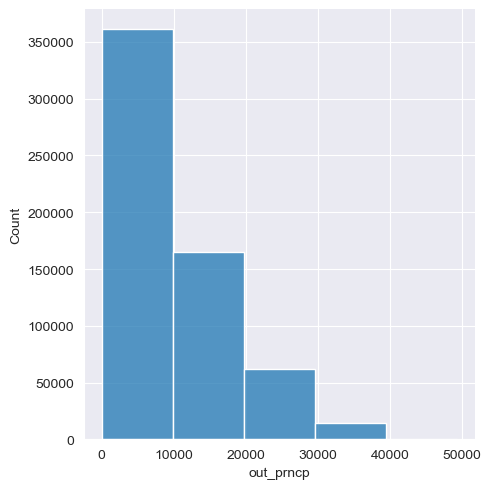

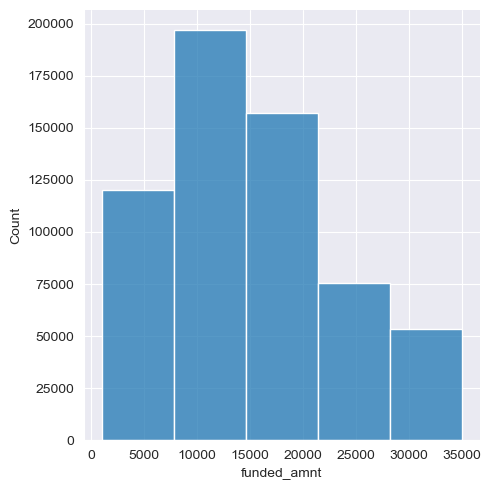

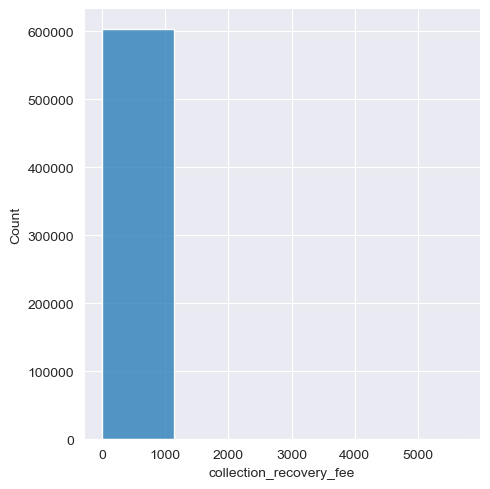

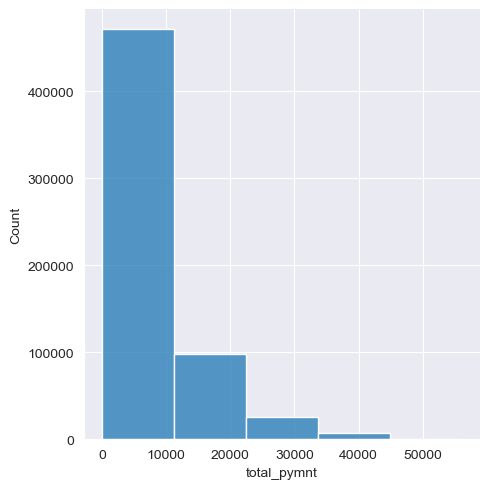

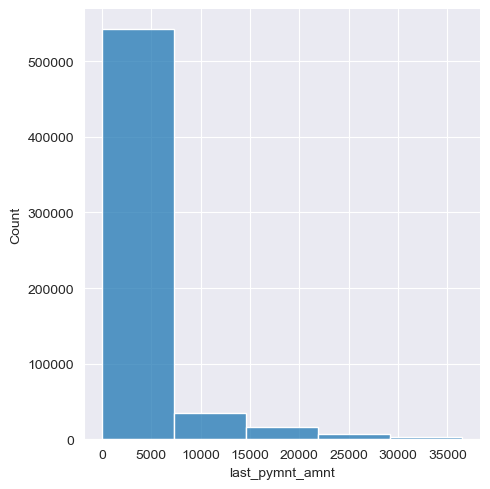

In [25]:
for col in train_X.columns:
    sns.displot(train_X, x=col, bins=5)

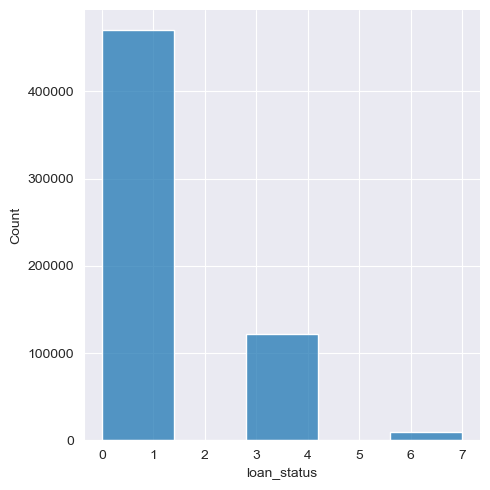

In [28]:
sns.displot(train_y,bins=5)